In [1]:
from ModularCirc.Models.NaghaviModel import NaghaviModel, NaghaviModelParameters
from ModularCirc.Solver import Solver

import ModularCirc.StateVariable as sv
import matplotlib.pyplot as plt
import numpy  as np

Define the duration of the simulation in terms of the number of cycles, the duration of a time cycle (ms) and the duration of a time step.

In [2]:
TEMPLATE_TIME_SETUP_DICT = {
    'name'    :  'TimeTest',
    'ncycles' :  40,
    'tcycle'  :  800.,
    'dt'      :  1.0,
 }

The parameters object used to constrain the model.

In [3]:
parobj = NaghaviModelParameters()
# parobj.set_chamber_comp('lv', tau=100.)
# parobj.set_chamber_comp('la', tau=100.)
# parobj.set_rc_comp('ao', c=0.025)

Define an instance of the model using the parameter object.

In [4]:
model = NaghaviModel(TEMPLATE_TIME_SETUP_DICT, parobj=parobj)

Naghavi Model parameters set: 
 * Component - ao
  - r       : 3.200e+04
  - c       : 2.500e-03
  - l       : 0.000e+00
  - v_ref   : 1.000e+02
  - v       : 1.300e+02
  - p       : None

 * Component - art
  - r       : 1.500e+05
  - c       : 2.500e-02
  - l       : 0.000e+00
  - v_ref   : 5.000e+01
  - v       : 1.092e+03
  - p       : None

 * Component - ven
  - r       : 1.200e+03
  - c       : 1.000e+00
  - l       : 0.000e+00
  - v_ref   : 2.800e+03
  - v       : 3.780e+03
  - p       : None

 * Component - av
  - r       : 8.000e+02
  - max_func : <function relu_max at 0x171fac040>

 * Component - mv
  - r       : 5.500e+02
  - max_func : <function relu_max at 0x171fac040>

 * Component - la
  - E_pas   : 6.000e+01
  - E_act   : 5.867e+01
  - V_ref   : 1.000e+01
  - activation_function : <function activation_function_2 at 0x171fac3a0>
  - t_max   : 1.500e+02
  - t_tr    : 2.250e+02
  - tau     : 1.750e+02
  - delay   : 1.000e+02
  - V       : 9.360e+01
  - P       : None

 * 

Define a solver to run the model.

In [5]:
solver = Solver(model=model)
solver.setup()

 -- Variable v_ao added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
 -- Variable v_art added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
 -- Variable v_ven added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
 -- Variable v_la added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
 -- Variable v_lv added to the principal variable key list.
    - name of update function: chamber_volume_rate_change
 -- Variable p_lv added to the principal variable key list.
    - name of update function: self.comp_dpdt
 -- Variable q_av added to the secondary variable key list.
    - name of update function: non_ideal_diode_flow + max_func
 -- Variable p_ao added to the principal variable key list.
    - name of update function: lambda grounded_capacitor_model_dpdt
 -- Variable p_art added to the principal variable 

In [6]:
%prun -l 40 -s cumtime solver.solve()
# solver.solve()

         22968088 function calls (22583943 primitive calls) in 8.551 seconds

   Ordered by: cumulative time
   List reduced from 602 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.551    8.551 {built-in method builtins.exec}
        1    0.000    0.000    8.551    8.551 <string>:1(<module>)
        1    0.000    0.000    8.551    8.551 Solver.py:103(solve)
        1    0.086    0.086    5.493    5.493 ivp.py:156(solve_ivp)
    32010    0.034    0.000    4.934    0.000 base.py:175(step)
    32010    0.529    0.000    4.899    0.000 bdf.py:309(_step_impl)
    32010    0.306    0.000    3.608    0.000 bdf.py:36(solve_bdf_system)
        1    0.000    0.000    3.055    3.055 frame.py:10143(apply)
        1    0.013    0.013    3.055    3.055 apply.py:864(apply)
        1    0.000    0.000    3.042    3.042 apply.py:1061(apply_standard)
    64184    0.020    0.000    2.722    0.000 base.py:152(fun)
   

In [7]:
ind1 = -2*model.time_object.n_c+1
ind2 = -1

v_lv = solver.model.commponents['lv'].V.values[ind1:ind2]
p_lv = solver.model.commponents['lv'].P_i.values[ind1:ind2]

v_la = solver.model.commponents['la'].V.values[ind1:ind2]
p_la = solver.model.commponents['la'].P_i.values[ind1:ind2]

t = model.time_object._sym_t[ind1:ind2].values
t -= t[0]

q_mv = solver.model.commponents['mv'].Q_i.values[ind1:ind2]
q_av = solver.model.commponents['av'].Q_i.values[ind1:ind2]
p_ao = solver.model.commponents['ao'].P_i.values[ind1:ind2]
q_ao = solver.model.commponents['ao'].Q_o.values[ind1:ind2]

af_lv = np.vectorize(model.commponents['lv']._af) 
af_la = np.vectorize(model.commponents['la']._af) 
tc = model.time_object._cycle_t[ind1:ind2]

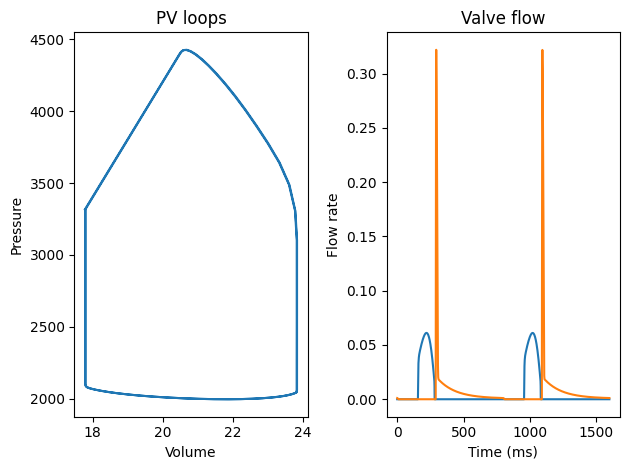

In [8]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(v_lv, p_lv)
ax[0].set_title('PV loops')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('Volume')

ax[1].plot(t, q_mv)
ax[1].plot(t, q_av)
ax[1].set_title('Valve flow')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Flow rate')

plt.tight_layout()
plt.show()

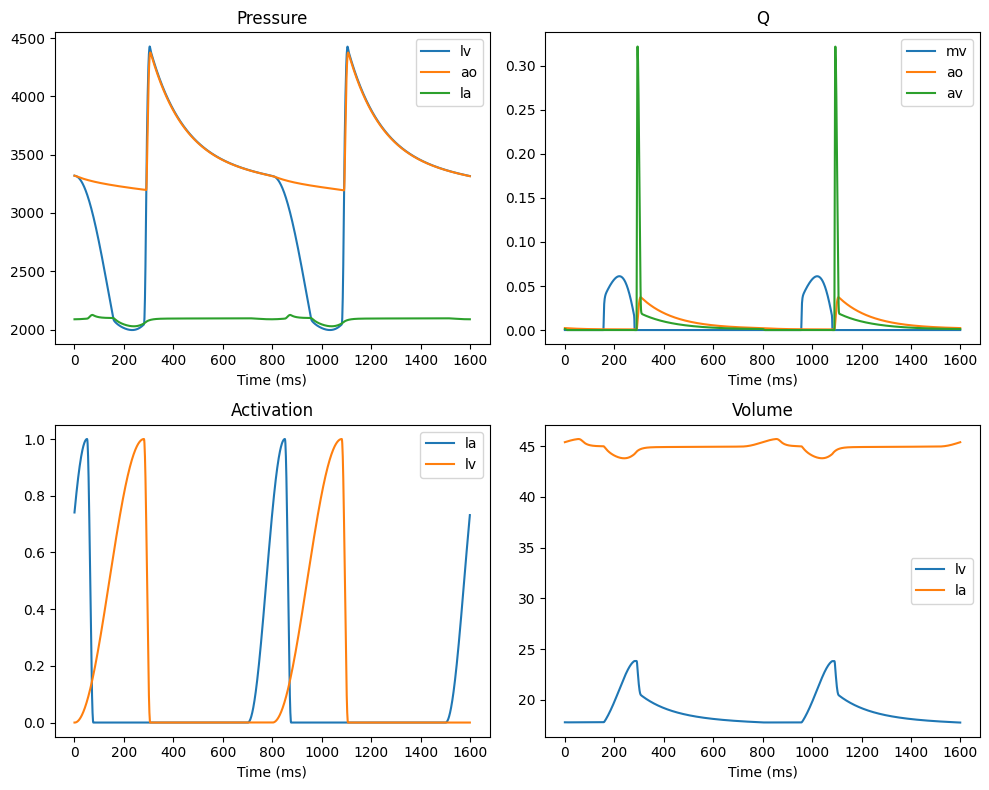

In [9]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

ax2[0][0].plot(t, p_lv, label='lv')
ax2[0][0].plot(t, p_ao, label='ao')
ax2[0][0].plot(t, p_la, label='la')
ax2[0][0].set_title('Pressure')
ax2[0][0].set_xlabel('Time (ms)')
ax2[0][0].legend()

ax2[0][1].plot(t, q_mv, label='mv')
ax2[0][1].plot(t, q_ao, label='ao')
ax2[0][1].plot(t, q_av, label='av')
ax2[0][1].set_title('Q')
ax2[0][1].set_xlabel('Time (ms)')
ax2[0][1].legend()

ax2[1][0].plot(t, af_la(tc), label='la')
ax2[1][0].plot(t, af_lv(tc), label='lv')
ax2[1][0].set_title('Activation')
ax2[1][0].set_xlabel('Time (ms)')
ax2[1][0].legend()

ax2[1][1].plot(t, v_lv, label='lv')
ax2[1][1].plot(t, v_la, label='la')
ax2[1][1].set_title('Volume')
ax2[1][1].set_xlabel('Time (ms)')
ax2[1][1].legend()

plt.tight_layout()
plt.show()